In [33]:
# IMPORTANT: change this to your locations
model_h5_file_location = f'/scratch/ms7490/code/splicing_library_analysis/2022_03_11_figures/models/custom_adjacency_regularizer_20210731_124_step3.h5'
data_folder = f'/scratch/ms7490/code/splicing_library_analysis/2022_03_11_figures/data'

# for webscraping Vienna Forna
geckodriver_path = '/home/ms7490/scratch/other-code/geckodriver/geckodriver'
firefox_binary_path = '/home/ms7490/scratch/other-code/geckodriver/firefox/firefox'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patches as pat
from matplotlib import transforms
from matplotlib import colors
from matplotlib.collections import PatchCollection
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from joblib import load, dump
import re
import time
import scipy.cluster.hierarchy as sch
from scipy.signal import find_peaks

# custom code
import figutils
sys.path.insert(
    0, os.path.abspath('../2021_07_31_custom_adjacency_regularization/'))
import sequence_logo
from quad_model import *
import kl
import force

from typing import Iterable
from IPython.display import Image, display, SVG
import pygraphviz as pgv

from collections.abc import Iterable
import einops

%matplotlib inline

2022-09-22 23:23:20.732854: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/.singularity.d/libs
2022-09-22 23:23:20.732897: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Matplotlib is building the font cache; this may take a moment.


In [4]:
from selenium import webdriver

from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.support.ui import WebDriverWait

from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup

In [5]:
plt.style.use('clean.mplstyle')

# Load data and models

In [6]:
xTr = load(os.path.join(data_folder, f'xTr_ES7_HeLa_ABC.pkl'))
yTr = load(os.path.join(data_folder, f'yTr_ES7_HeLa_ABC.pkl'))
xTe = load(os.path.join(data_folder, f'xTe_ES7_HeLa_ABC.pkl'))
yTe = load(os.path.join(data_folder, f'yTe_ES7_HeLa_ABC.pkl'))

In [7]:
model_fname = model_h5_file_location
model = tf.keras.models.load_model(model_fname)

2022-09-22 23:30:31.923264: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/.singularity.d/libs
2022-09-22 23:30:31.923304: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-22 23:30:31.923320: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cm001.hpc.nyu.edu): /proc/driver/nvidia/version does not exist
2022-09-22 23:30:31.923506: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
num_seq_filters = model.get_layer('qc_incl').kernel.shape[2]
num_struct_filters = model.get_layer('c_incl_struct').kernel.shape[2]

position_bias_size = model.get_layer('position_bias_incl').kernel.shape[0]
struct_filter_width = model.get_layer("c_incl_struct").kernel.shape[0]
input_length = model.input[0].shape[1]

# Compute activations

In [9]:
structure_out_model = Model(inputs=model.inputs, outputs=[
    model.get_layer('activation_2').output,
    model.get_layer('activation_3').output
])

# Compute secondary structure peaks

In [11]:
# only includes skipping filters
loop_filters = np.array([0, 3, 2])

In [12]:
def is_far_enough_from_edge(n, exon_boundary_dist=20, len_seq=90):
    return n - exon_boundary_dist >= 0 and len_seq - exon_boundary_dist >= n

In [13]:
def pad_string_idx(x, peak_hint, window, prefix_pad, suffix_pad):
    idxs = np.array([np.nan] * prefix_pad + list(range(len(x))) + [np.nan] * suffix_pad)
    padded_str = ('-' * prefix_pad + x + '-' * suffix_pad)
    return idxs, padded_str

In [14]:
def localize_loop(x, peak_hint, window=10, prefix_pad=2, suffix_pad=3):
    idxs, padded_x = pad_string_idx(x, peak_hint, window, prefix_pad, suffix_pad)
    trimmed_region = padded_x[peak_hint-window:peak_hint+window]
    trimmed_idxs = idxs[peak_hint-window:peak_hint+window]
    
    e = trimmed_region
    a = trimmed_idxs
    
    A, B = idxs, padded_x
    
    left_idx = peak_hint
    right_idx = peak_hint
    
    left_bracket_encountered = right_bracket_encountered = False
    left_finished = right_finished = False

    while not left_finished:
        if left_idx < 0:
            raise RuntimeError('No end found')
        if B[left_idx] == '(':
            left_bracket_encountered = True
            left_finished = True
        else:
            left_idx -= 1

    while not right_finished:
        if right_idx >= len(B):
            raise RuntimeError('No end found')
        if B[right_idx] == ')':
            right_bracket_encountered = True
            right_finished = True
        else:
            right_idx += 1
    right_idx += 1
    
    left_idx_start = left_idx
    right_idx_start = right_idx
    
    while True:
        if left_idx < 0 or right_idx >= len(B):
            raise RuntimeError('No end found')
        if B[left_idx] != '(' or B[right_idx] != ')':
            break
        else:
            left_idx -= 1
            right_idx += 1
    
    return A[left_idx:left_idx_start+1], A[right_idx_start-1:right_idx]

In [15]:
def augment_position(seq, pos, alphabet={'A', 'C', 'G', 'U'}):
    remaining_alphabet = alphabet - {seq[pos]}
    out = []
    for e in remaining_alphabet:
        seq_copy = list(str(seq))
        seq_copy[pos] = e
        out.append(''.join(seq_copy))
    return out

In [16]:
def compute_aug_seq_acts(seq, pos, structure_acts_model):
    aug_seqs = augment_position(seq, pos)
    aug_seqs_input = figutils.create_input_data(aug_seqs)
    
    return structure_acts_model.predict(aug_seqs_input).sum(axis=-1)

In [17]:
def compute_aug_seq_acts_batch(seq, structure_acts_model):
    all_augs = [augment_position(seq, pos) for pos, _ in enumerate(seq)]
    all_augs_flat = [e for a in all_augs for e in a]
    all_augs_flat_input = figutils.create_input_data(all_augs_flat)
    struct_preds = structure_acts_model.predict(all_augs_flat_input).sum(axis=-1)
    
    out = []
    ctr = 0
    for e in all_augs:
        out.append(
            struct_preds[ctr:ctr+len(e)]
        )
        ctr += len(e)
    return out

In [18]:
def compute_aug_seq_acts_batches(seqs, structure_acts_model):
    all_augs = [[augment_position(seq, pos) for pos, _ in enumerate(seq)] for seq in tqdm(seqs, leave=False)]
    all_augs_flat = [e for b in all_augs for a in b for e in a]
    all_augs_flat_input = figutils.create_input_data(all_augs_flat)
    struct_preds = structure_acts_model.predict(all_augs_flat_input).sum(axis=-1)
    
    return struct_preds.reshape(len(seqs), -1, 3)
    
    # print(len(all_augs_flat))

In [19]:
def compute_baseline_act(seq, structure_acts_model):
    return structure_acts_model.predict(figutils.create_input_data([seq])).sum(axis=-1)

In [20]:
def compute_baseline_acts(seqs, structure_acts_model):
    return structure_acts_model.predict(figutils.create_input_data(seqs)).sum(axis=-1)

In [21]:
def compute_aug_seq_acts_diff(seq, structure_acts_model, pad=True):
    assert isinstance(seq, str)
    baseline_act = compute_baseline_act(seq, structure_acts_model)
    
    aug_seq_acts = compute_aug_seq_acts_batch(seq, structure_acts_model)
    
    out = np.stack(aug_seq_acts)

    out = np.abs(baseline_act - out).mean(axis=-1)
    if not pad:
        return out
    
    return np.pad(out, pad_width=[(0, 5)], mode='constant', constant_values=0)

In [22]:
def compute_aug_seqs_acts_diff(seqs, structure_acts_model, pad=False):
    assert isinstance(seqs, Iterable)
    baseline_acts = compute_baseline_acts(seqs, structure_acts_model)
    
    out = compute_aug_seq_acts_batches(seqs, structure_acts_model)

    out = np.abs(baseline_acts[:, None, None] - out).mean(axis=-1)
    if not pad:
        return out
    
    return np.pad(out, pad_width=[(0, 5)], mode='constant', constant_values=0)

In [23]:
def print_formatted_sensitivities(sensitivities):
    for e in sensitivities:
        print(np.round(e, decimals=3), end=' ')
    print()

In [24]:
def print_peak_hint(pos, n):
    s1 = ' '*pos + '|' + ' ' * (n - 2 - pos)
    s2 = ' '*pos + 'V' + ' ' * (n - 2 - pos)
    print(s1)
    print(s2)

In [25]:
def normalize(x):
    if len(x.shape) == 1:
        return np.array(x) / np.array(x).max()
    if len(x.shape) == 2:
        return np.array(x) / np.array(x).max(axis=-1)[:, None]
    raise NotImplementedError('eee')

In [26]:
structure_acts_model = Model(inputs=model.inputs, outputs=[
    sum([model.get_layer('activation_3').output[..., num_seq_filters + lfi]
        for lfi in loop_filters])
])

In [27]:
structure_intermediate_outputs_model = Model(inputs=model.inputs, outputs=[
    model.get_layer('c_skip_struct').output,
    model.get_layer('position_bias_skip_struct').output,
    model.get_layer('concatenate_2').output,
    model.get_layer('activation_3').output,
])

In [28]:
def softplus(x):
    return np.log(1 + np.exp(x))

In [29]:
def sum_to_one(x):
    assert (x >= 0).all()
    return x / x.sum()

In [30]:
def relu(x):
    return np.maximum(0, x)

In [31]:
def compute_contrib(seq, peak_hint, model, struct_activation_offset=2):
    inps = figutils.create_input_data([seq])
    inps_cat = np.concatenate(inps, axis=-1)

    cW, cB = model.get_layer('c_skip_struct').get_weights()
    pW, = model.get_layer('position_bias_skip_struct').get_weights()

    kernel_size, num_channels, num_filters = cW.shape

    b = tf.expand_dims(inps_cat, axis=(2,))
    v = tf.image.extract_patches(
                b,
                sizes=[1, cW.shape[0], 1, 1],
                strides=[1, 1, 1, 1],
                rates=[1, 1, 1, 1],
                padding="SAME",
            )
    w = tf.squeeze(v, axis=2).numpy().reshape(-1, inps_cat.shape[1], kernel_size, num_filters)
    # tmp = np.einsum('abcd,cde->abcde', w, cW).sum(axis=-2)[..., loop_filters][:, peak_hint + struct_activation_offset].sum(axis=-1)
    tmp2 = np.einsum('abcd,cde->abcde', w, cW) + (cB / (kernel_size * num_channels)).reshape(1, 1, 1, 1, num_filters)
    tmp3 = tmp2 + (pW / (kernel_size * num_channels)).reshape(1, input_length, 1, 1, num_filters)
    
    offset = 10
    assert offset != 0
    saliency_location = tf.image.extract_patches(
                (offset + np.arange(inps_cat.shape[1])).reshape(1, -1, 1, 1),
                sizes=[1, kernel_size, 1, 1],
                strides=[1, 1, 1, 1],
                rates=[1, 1, 1, 1],
                padding="SAME",
            ).numpy().squeeze(axis=(0, 2))[struct_activation_offset+peak_hint]
    saliency_location = saliency_location.astype(float)
    saliency_location[saliency_location == 0] = np.nan
    saliency_location -= offset

    return tmp3, saliency_location
    
    
def compute_saliency(seq, peak_hint, model, loop_filters, struct_activation_offset=2):
    pos_bias_out, saliency_location = compute_contrib(seq, peak_hint, model,
                                                      struct_activation_offset=struct_activation_offset)
    pos_bias_loop = pos_bias_out[:, struct_activation_offset+peak_hint][..., loop_filters]
    filter_selector = (np.einsum('n w c f -> f', pos_bias_loop) > 0)
    print(loop_filters[filter_selector])
    sal_raw = np.einsum('n w c f -> w', pos_bias_loop[..., filter_selector])
    sal = fill_array(saliency_location, sal_raw)
    
    return sal

In [32]:
def fill_array(indices, values, max_len=90):
    out = np.zeros(max_len)
    
    for i, v in zip(indices, values):
        out[int(i)] = v
    return out

def relu(x):
    return np.maximum(0, x)

In [34]:
def get_browser():
    service = Service(executable_path=geckodriver_path)
    
    options = Options()
    options.binary_location = firefox_binary_path

    options.set_preference("browser.download.folderList", 2)
    options.set_preference("browser.download.manager.showWhenStarting", False)
    options.set_preference("browser.download.dir", data_folder)
    options.set_preference("browser.helperApps.neverAsk.saveToDisk", "image/svg+xml")
    
    options.add_argument('--headless')
    
    browser = webdriver.Firefox(options=options, service=service)
    
    return browser

In [35]:
def get_forna_url(seq, seq_ss):
    return f'http://nibiru.tbi.univie.ac.at/forna/forna.html?id=url/name&sequence={seq}&structure={seq_ss}'

In [36]:
def create_svg_soup(svg_string):
    soup = BeautifulSoup(svg_string,'xml')
    
    soup.find('svg')['xmlns:xlink'] = "http://www.w3.org/1999/xlink"
    soup.find('svg')['xmlns'] = "http://www.w3.org/2000/svg"
    
    return soup

In [37]:
def get_svg_object(seq, seq_ss, browser):
    forna_url = get_forna_url(seq, seq_ss)

    browser.get(forna_url)
    time.sleep(3)
    
    svg = browser.find_element(by=By.TAG_NAME, value='svg')
    return create_svg_soup(svg.get_attribute('outerHTML'))

In [38]:
def color_nucleotides(svg_object, colors):
    nucleotides = [e for e in svg_object.find_all(name='circle') if e['class'] == 'node' and e['node_type'] == 'nucleotide']
    
    assert len(nucleotides) == len(colors)
    
    for nt, color in zip(nucleotides, colors):
        nt['style'] = f"fill: {color};"
    
    return svg_object

In [39]:
def saliency_to_hex(saliency, cm=plt.cm.Reds, scaling_fn=normalize): 
    snorm = scaling_fn(seq_saliency)
    
    return [colors.to_hex(cm(c)[:3]).upper() for c in snorm]

In [40]:
def rescale(a, mn, mx):
    return np.interp(a, (a.min(), a.max()), (mn, mx))

In [41]:
browser = get_browser()

In [42]:
raw_exons_to_plot = {
    '2c1':'GAGTCCCGCTTACCATTGCATTTAAGAAAGCGGCCATACGCCGCTAAGACCCTACTCTTCAGAATACCAG',
    '2c4':'TCGCTCTCTAAAAAAGTCACCTACTTAACACGACGTGCCTCCGTGGCACGAAAATAAACCACTAAGAAAA',
    '2c5':'TCTGCCCCTACACACAGGCACCTCGGCGATCGCCCGGGACACATCCGGGCCCTTGTTTCTATTCCGCCTC',
    '2c6':'ACGGAACCGCCTGTCGGTTCCCACCCGTCTACCATGCACATACTCCTCTTTTTTGACCCGAAAACCTCCA'
}

In [43]:
padded_exons = [
    figutils.add_flanking(e.replace('T', 'U'), 10) for e in raw_exons_to_plot.values()
]

In [44]:
exons_to_plot_data = figutils.create_input_data(padded_exons)
exons_incl_act, exons_skip_act = structure_out_model.predict(exons_to_plot_data, verbose=1)
exons_peak_hints = [find_peaks(exon_row, height=2)[
    0][0] for exon_row in exons_skip_act[..., num_seq_filters + loop_filters].sum(axis=2)]

2022-09-22 23:34:36.710271: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1/1 [==============================] - 2s 2s/step


In [45]:
seq_saliencies = []

for seq, peak_hint in zip(tqdm(padded_exons), exons_peak_hints):
    seq_ss = figutils.compute_structure([seq])[1][0]
    seq_saliency = compute_saliency(seq, peak_hint, model, loop_filters) + compute_saliency(seq, peak_hint-1, model, loop_filters) + compute_saliency(seq, peak_hint+1, model, loop_filters)
    seq_saliencies.append(seq_saliency)

  0%|          | 0/4 [00:00<?, ?it/s]

[0 2]
[0 2]
[0 2]
[0 2]
[]
[0 2]
[0]
[0]
[0]
[0]
[0]
[0]


In [46]:
norm = colors.TwoSlopeNorm(0, np.min(seq_saliencies), np.max(seq_saliencies))

In [47]:
ctr = 0
for seq, seq_saliency in zip(tqdm(padded_exons), seq_saliencies):
    seq_ss = figutils.compute_structure([seq])[1][0]
    
    svg_object = get_svg_object(seq, seq_ss, browser)
    svg_saliency_hex_colors = saliency_to_hex(seq_saliency, cm=plt.cm.bwr, scaling_fn=lambda x: norm(x).data)
    svg_object_colored = color_nucleotides(svg_object, svg_saliency_hex_colors)
    
    with open(f"./figs/ss_{ctr}.svg", "w") as file:
        file.write(svg_object_colored.prettify())
    
    ctr += 1

  0%|          | 0/4 [00:00<?, ?it/s]

In [48]:
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.set_yticks([])

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


[28, 428, 828, 1228, 1628]


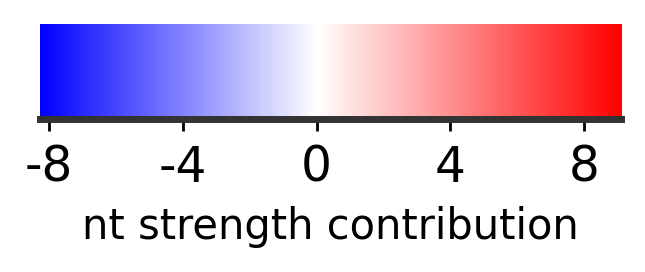

In [49]:
fig, ax = plt.subplots(figsize=(3, 0.5), dpi=250)
a = np.outer(np.arange(norm.vmin, norm.vmax, 0.01), np.ones(10)).T
ax.imshow(a, aspect='auto', cmap=plt.cm.bwr, origin="lower", norm=norm)
simpleaxis(ax)
xlabels = [-8, -4, 0, 4, 8]
print([np.abs(a[0] - e).argmin() for e in xlabels])
ax.set_xticks([np.abs(a[0] - e).argmin() for e in xlabels])
ax.set_xticklabels(xlabels)
ax.set_xlabel('nt strength contribution', fontsize=12)
fig.savefig('./figs/secondary_structure_contribution_colorbar.svg',
            transparent=True, pad_inches=0.1,
    bbox_inches='tight')
plt.show()